# Summary
Prepare data for data visualisation team:
- Save processed, only annotated with inchikey spectra
- Create 2D + 3D tSNE of these spectra after converting these spectra to embedding vectors
- Save both tSNE outputs linked by spectrum_ids
- Save classifications file linked by spectrum_ids

In [1]:
import os
import gensim
import pickle
import time
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Load preprocessed data

In [2]:
data_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/ALL_GNPS_210409_positive/"
embedding_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/embeddings/ALL_GNPS_210409_positive/"

base = "ALL_GNPS_210409_positive_cleaned"
spectrum_file = os.path.join(data_path, base+".pickle")
os.path.exists(spectrum_file)

True

In [3]:
processed_spectrums_file = os.path.join(data_path, base+"_peaks_processed_s2v.pickle")
with open(processed_spectrums_file, 'rb') as inf:
    spectrums_processed = pickle.load(inf)
len(spectrums_processed)

199780

### Keep annotated spectra
Annotated with inchikey

In [4]:
annot_spectrums_processed = []
for spec in spectrums_processed:
    inchikey = spec.metadata.get("inchikey")
    if inchikey:
        annot_spectrums_processed.append(spec)
len(annot_spectrums_processed)

187152

In [5]:
spectrums_ids = [s.metadata.get("spectrum_id") for s in annot_spectrums_processed]

In [6]:
any([s==None for s in spectrums_ids])

False

### Save as json

In [11]:
from matchms.exporting import save_as_json
out_json = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated.json")
print(out_json)
save_as_json(annot_spectrums_processed, out_json)

/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/ALL_GNPS_210409_positive/ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated.json


In [13]:
out_annot_proc = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated.pickle")
with open(out_annot_proc, 'wb') as outf:
    pickle.dump(annot_spectrums_processed, outf)

### Create spectral embedding vectors

In [7]:
# import model
model_file = os.path.join(embedding_path, "ALL_GNPS_210409_positive_cleaned_spec2vec_embedding_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [8]:
from spec2vec import SpectrumDocument
documents_spectrums_processed = [SpectrumDocument(s, n_decimals=2) for s in annot_spectrums_processed]
print(len(documents_spectrums_processed))

187152


In [9]:
from spec2vec.vector_operations import calc_vector
spectrum_vectors = [calc_vector(model, s) for s in documents_spectrums_processed]

In [36]:
spectrum_vectors_weighted = [calc_vector(model, s, intensity_weighting_power=0.5) for s in documents_spectrums_processed]

In [37]:
spectrum_vectors_weighted = np.vstack(spectrum_vectors_weighted)
spectrum_vectors_weighted.shape

(187152, 300)

In [10]:
# and for UniqueInchikey
sys.path.insert(0, os.path.join(os.path.split(os.getcwd()[:-1])[0], "scripts"))
from mass_differences.processing import get_ids_for_unique_inchikeys

uniq_ids = get_ids_for_unique_inchikeys(annot_spectrums_processed)
spectrum_vectors_unique = [spectrum_vectors[i] for i in uniq_ids]
spectrum_vectors_unique = np.vstack(spectrum_vectors_unique)
spectrum_vectors_unique.shape

(16360, 300)

### Compute tSNE

In [23]:
spectrum_vectors = np.vstack(spectrum_vectors)

In [26]:
spectrum_vectors.shape

(187152, 300)

In [30]:
#2d
from sklearn.manifold import TSNE
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_res = tsne_2d.fit_transform(spectrum_vectors)

In [39]:
#2d weighted
from sklearn.manifold import TSNE
tsne_2d_w = TSNE(n_components=2, random_state=42)
tsne_2d_w_res = tsne_2d_w.fit_transform(spectrum_vectors_weighted)
tsne_2d_w_pickle = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne2D.pickle")
pickle.dump(tsne_2d_w_res, open(tsne_2d_w_pickle, 'wb'))

In [31]:
#3d
from sklearn.manifold import TSNE
tsne_3d = TSNE(n_components=3, random_state=42)
tsne_3d_res = tsne_3d.fit_transform(spectrum_vectors)

In [42]:
#3d weighted
from sklearn.manifold import TSNE
tsne_3d_w = TSNE(n_components=3, random_state=42)
tsne_3d_w_res = tsne_3d_w.fit_transform(spectrum_vectors_weighted)
tsne_3d_w_pickle = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne3D.pickle")
pickle.dump(tsne_3d_w_res, open(tsne_3d_w_pickle, 'wb'))

In [32]:
tsne_2d_res.shape, tsne_3d_res.shape

((187152, 2), (187152, 3))

### Save tSNE results

In [40]:
print(tsne_2d_res[0])
for a in tsne_2d_res:
    print(','.join(map(str,a)))
    break

[ -3.786377 -23.733685]
-3.786377,-23.733685


In [34]:
tsne_2d_pickle = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_tsne2D.pickle")
tsne_3d_pickle = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_tsne3D.pickle")
pickle.dump(tsne_2d_res, open(tsne_2d_pickle, 'wb'))
pickle.dump(tsne_3d_res, open(tsne_3d_pickle, 'wb'))

In [43]:
tsne_2d_w_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne2D.csv")
with open(tsne_2d_w_out, 'w') as outf:
    for s_id, tsne_r in zip(spectrums_ids, tsne_2d_w_res):
        outf.write("{},{}\n".format(s_id, ','.join(map(str, tsne_r))))

In [44]:
tsne_3d_w_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne3D.csv")
with open(tsne_3d_w_out, 'w') as outf:
    for s_id, tsne_r in zip(spectrums_ids, tsne_3d_w_res):
        outf.write("{},{}\n".format(s_id, ','.join(map(str, tsne_r))))

In [45]:
# Load tsne data - from weighted run
tsne_2d_w_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne2D.pickle")
tsne_3d_w_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne3D.pickle")
tsne_2d_w_res = pickle.load(open(tsne_2d_w_out, 'rb'))
tsne_3d_w_res = pickle.load(open(tsne_3d_w_out, 'rb'))
tsne_2d_w_res.shape, tsne_3d_w_res.shape

((187152, 2), (187152, 3))

In [46]:
# Load tsne data
tsne_2d_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_tsne2D.pickle")
tsne_3d_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_tsne3D.pickle")
tsne_2d_res = pickle.load(open(tsne_2d_out, 'rb'))
tsne_3d_res = pickle.load(open(tsne_3d_out, 'rb'))
tsne_2d_res.shape, tsne_3d_res.shape

((187152, 2), (187152, 3))

### Link classifications to selected spectra

In [13]:
classifications_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/"
classes_file = os.path.join(classifications_path, "ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt")
classes = {}  # inchikey: [classes] in order of header
with open(classes_file) as inf:
    header = inf.readline().strip().split('\t')
    for line in inf:
        line = line.strip().split('\t')
        classes[line[0]] = line[2:]
print(f'read classes for {len(classes)} inchikeys')
print("\nclasses order:")
print(header)

read classes for 19824 inchikeys

classes order:
['inchi_key', 'smiles', 'cf_kingdom', 'cf_superclass', 'cf_class', 'cf_subclass', 'cf_direct_parent', 'npc_class_results', 'npc_superclass_results', 'npc_pathway_results', 'npc_isglycoside']


In [14]:
spectra_classes = []
empty_class = ["" for _ in range(len(header)-2)]
assert len(empty_class) == len(header)-2
for s_id, spec in zip(spectrums_ids, annot_spectrums_processed):
    inchikey = spec.metadata.get("inchikey")
    s_classes = classes.get(inchikey, empty_class)
    assert len(s_classes) == len(header)-2
    res = [s_id] + s_classes
    spectra_classes.append(res)
print(len(spectra_classes))
print(spectra_classes[:2])

187152
[['CCMSLIB00000001547', 'Organic compounds', 'Organic acids and derivatives', 'Peptidomimetics', 'Hybrid peptides', 'Hybrid peptides', 'Cyclic peptides; Microcystins', 'Oligopeptides', 'Amino acids and Peptides', '0'], ['CCMSLIB00000001548', 'Organic compounds', 'Organic acids and derivatives', 'Peptidomimetics', 'Depsipeptides', 'Cyclic depsipeptides', 'Cyclic peptides', 'Oligopeptides', 'Amino acids and Peptides', '0']]


In [15]:
new_header = ['spectrum_id'] + header[2:]
assert len(new_header) == len(spectra_classes[0])
print(new_header)

['spectrum_id', 'cf_kingdom', 'cf_superclass', 'cf_class', 'cf_subclass', 'cf_direct_parent', 'npc_class_results', 'npc_superclass_results', 'npc_pathway_results', 'npc_isglycoside']


In [51]:
spectrum_classes_file = os.path.join(classifications_path, "ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated_classes.txt")
print(spectrum_classes_file)
with open(spectrum_classes_file, 'w') as outf:
    outf.write(f"{','.join(new_header)}\n")
    for line_list in spectra_classes:
        outf.write(f"{','.join(line_list)}\n")

/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated_classes.txt


### Inspect tsne

In [50]:
import seaborn as sns
nice_colours = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#FFFFFF', '#000000']
len(nice_colours)

22

In [51]:
tsne_palette = sns.set_palette(sns.color_palette(nice_colours))

In [80]:
from collections import Counter
i_chosen = -3
chosen_classes = []
for s_cl in spectra_classes:
    chosen_class = s_cl[i_chosen]
    if not chosen_class:
        chosen_class = "Unclassified"
    else:  # separate in single classes - there are compounds with 3 superclasses for example
        chosen_class = chosen_class.split("; ")[0]
    chosen_classes.append(chosen_class)

print(f"{len(set(chosen_classes))} classes in this category, {len(nice_colours)} colours to choose from")
colour_dict = {cl:nice_colours[min([i,len(nice_colours)-1])] for i, (cl, num) in enumerate(Counter(chosen_classes).most_common())}
colour_labels, colour_codes = zip(*colour_dict.items())
spectra_chosen_classes = [colour_dict[c_cl] for c_cl in chosen_classes]
print(colour_dict)
print(len(spectra_chosen_classes))
Counter(chosen_classes).most_common()

71 classes in this category, 22 colours to choose from
{'Flavonoids': '#E6194B', 'Unclassified': '#3CB44B', 'Glycerophospholipids': '#FFE119', 'Steroids': '#4363D8', 'Triterpenoids': '#F58231', 'Tryptophan alkaloids': '#911EB4', 'Coumarins': '#46F0F0', 'Tyrosine alkaloids': '#F032E6', 'Isoflavonoids': '#BCF60C', 'Glycerolipids': '#FABEBE', 'Sesquiterpenoids': '#008080', 'Diterpenoids': '#E6BEFF', 'Small peptides': '#9A6324', 'Monoterpenoids': '#FFFAC8', 'Fatty Acids and Conjugates': '#800000', 'Lignans': '#AAFFC3', 'Phenolic acids (C6-C1)': '#808000', 'Phenylpropanoids (C6-C3)': '#FFD8B1', 'Pseudoalkaloids (transamidation)': '#000075', 'Spingolipids': '#808080', 'Ornithine alkaloids': '#FFFFFF', 'Anthranilic acid alkaloids': '#000000', 'Lysine alkaloids': '#000000', 'Macrolides': '#000000', 'Oligopeptides': '#000000', 'Nicotinic acid alkaloids': '#000000', 'Pseudoalkaloids': '#000000', 'Polycyclic aromatic polyketides': '#000000', 'Nucleosides': '#000000', 'Meroterpenoids': '#000000', 

[('Flavonoids', 21664),
 ('Unclassified', 19551),
 ('Glycerophospholipids', 13717),
 ('Steroids', 9268),
 ('Triterpenoids', 9069),
 ('Tryptophan alkaloids', 8961),
 ('Coumarins', 8177),
 ('Tyrosine alkaloids', 6963),
 ('Isoflavonoids', 5529),
 ('Glycerolipids', 5126),
 ('Sesquiterpenoids', 5038),
 ('Diterpenoids', 4839),
 ('Small peptides', 4708),
 ('Monoterpenoids', 4459),
 ('Fatty Acids and Conjugates', 4451),
 ('Lignans', 4185),
 ('Phenolic acids (C6-C1)', 4009),
 ('Phenylpropanoids (C6-C3)', 3996),
 ('Pseudoalkaloids (transamidation)', 3291),
 ('Spingolipids', 3131),
 ('Ornithine alkaloids', 2716),
 ('Anthranilic acid alkaloids', 2466),
 ('Lysine alkaloids', 2369),
 ('Macrolides', 2177),
 ('Oligopeptides', 2091),
 ('Nicotinic acid alkaloids', 2037),
 ('Pseudoalkaloids', 1999),
 ('Polycyclic aromatic polyketides', 1802),
 ('Nucleosides', 1745),
 ('Meroterpenoids', 1403),
 ('Chromanes', 1334),
 ('Aromatic polyketides', 1090),
 ('Cyclic polyketides', 1069),
 ('Fatty acyls', 1047),
 ('

Showing classes for: npc_superclass_results


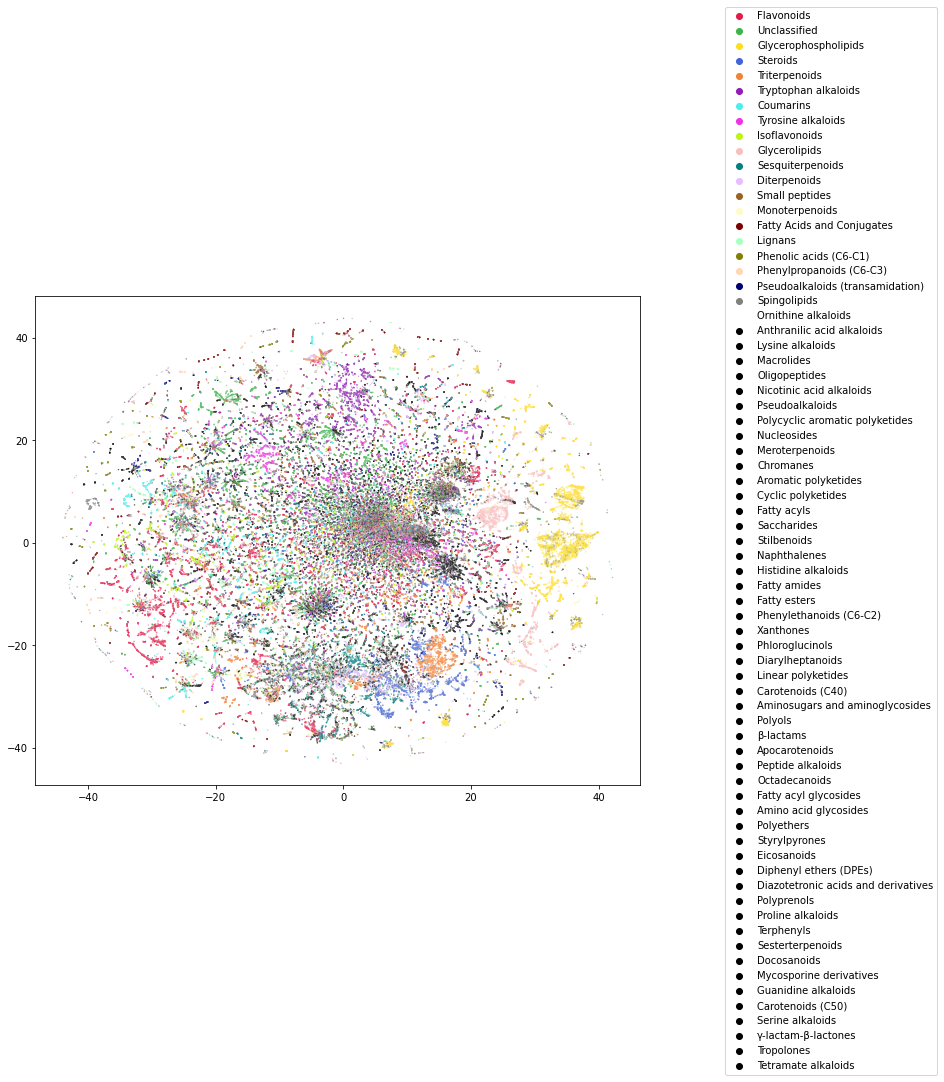

In [104]:
from collections import OrderedDict
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
ax = sns.scatterplot(
    x=tsne_2d_w_res[:,0], y=tsne_2d_w_res[:,1],
    hue=chosen_classes,
    palette=colour_dict,
    legend="full", alpha=0.4, s=2) #adjust dot size

box = plot.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
handles, labels = ax.get_legend_handles_labels()
by_label_unsorted = dict(zip(labels, handles))
by_label = OrderedDict([(lab,by_label_unsorted[lab]) for lab, count in Counter(chosen_classes).most_common()])
ax.legend(by_label.values(), by_label.keys(), loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
# ax.legend()
plt.savefig(os.path.join(classifications_path,
                         "ALL_GNPS_210409_positive_cleaned_NPC_superclasses.svg"))
# plt.show()

Showing classes for: npc_superclass_results


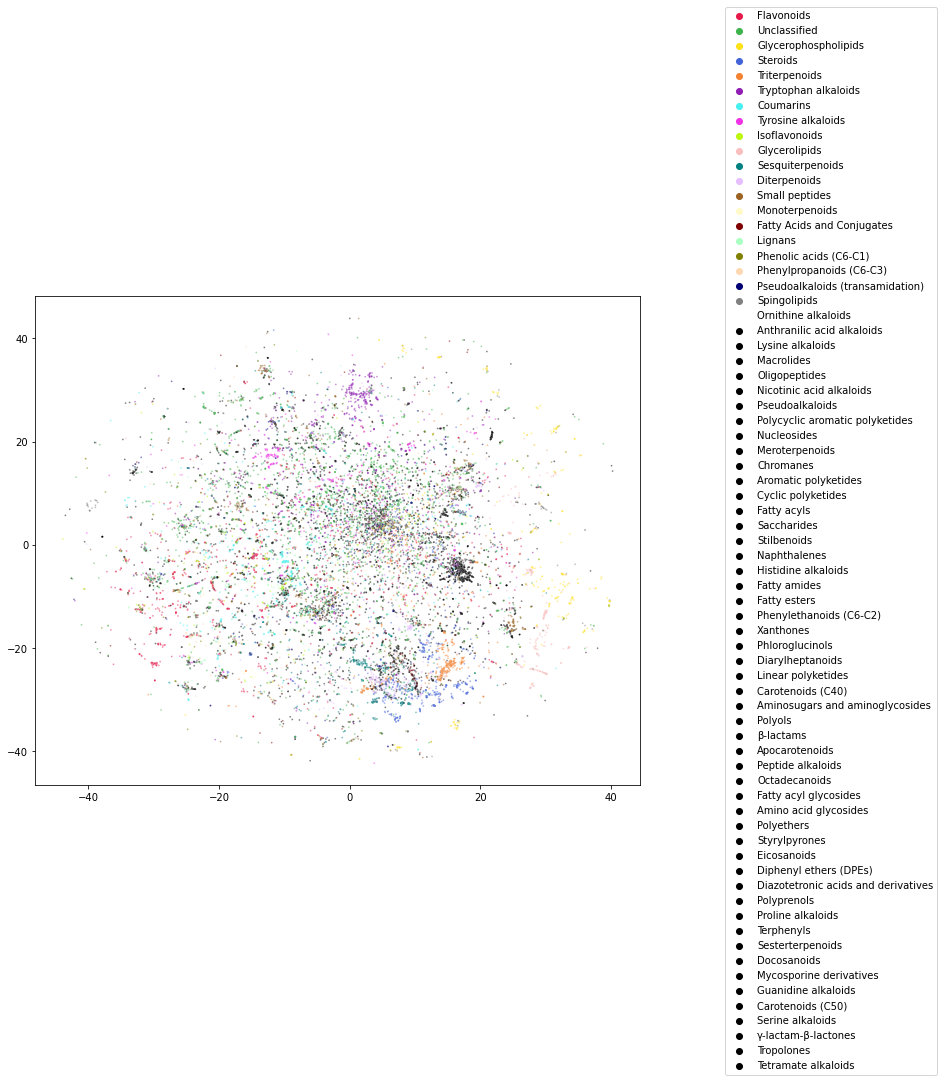

In [103]:
# UniqueInchikey - dot size and alpha are different than plot above
from collections import OrderedDict
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
ax = sns.scatterplot(
    x=np.take(tsne_2d_w_res[:,0], uniq_ids), y=np.take(tsne_2d_w_res[:,1], uniq_ids),
    hue=[chosen_classes[i] for i in uniq_ids],
    palette=colour_dict,
    legend="full", alpha=0.5, s=3) #adjust dot size

box = plot.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
# Put a legend to the right side
handles, labels = ax.get_legend_handles_labels()
by_label_unsorted = dict(zip(labels, handles))
by_label = OrderedDict([(lab,by_label_unsorted[lab]) for lab, count in Counter(chosen_classes).most_common()])
# by_label = OrderedDict(sorted(zip(labels, handles)))
ax.legend(by_label.values(), by_label.keys(), loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
# ax.legend()
plt.savefig(os.path.join(classifications_path,
                         "ALL_GNPS_210409_positive_cleaned_NPC_superclasses_unique_inchikeys.svg"))
# plt.show()

### Old plots with matplotlib
Weighting matters!

Showing classes for: npc_pathway_results


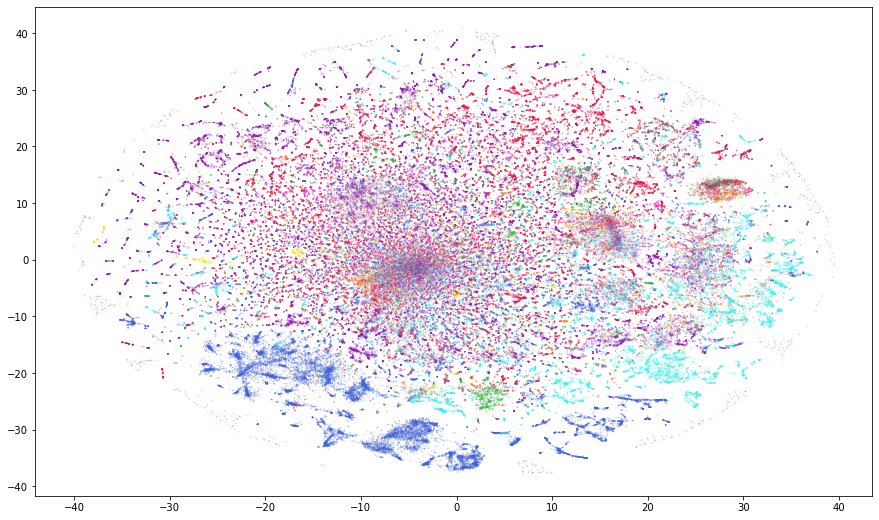

In [153]:
# Whole dataset 2D
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(tsne_2d_res[:,0],tsne_2d_res[:,1], 0.02, c=spectra_chosen_classes)
plt.show()

Showing classes for: npc_pathway_results


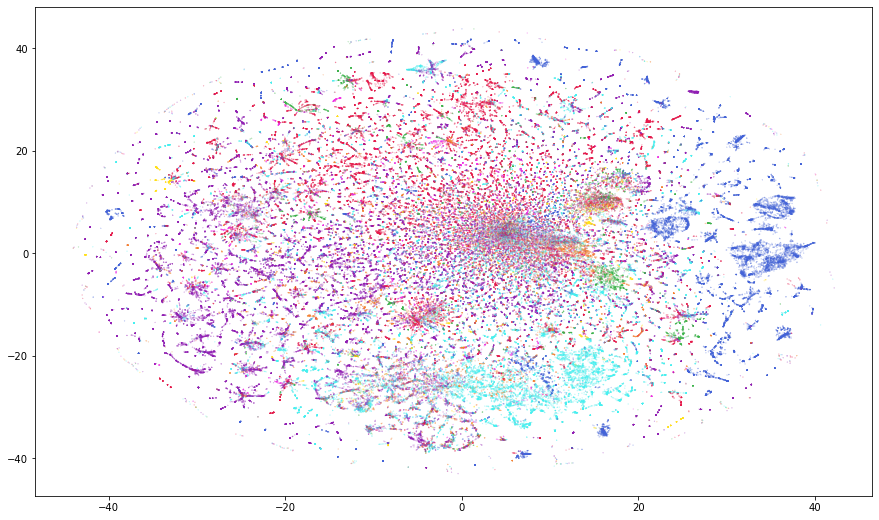

In [40]:
# Whole dataset 2D - weighted
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(tsne_2d_w_res[:,0],tsne_2d_w_res[:,1], 0.02, c=spectra_chosen_classes)
plt.show()

Showing classes for: npc_pathway_results


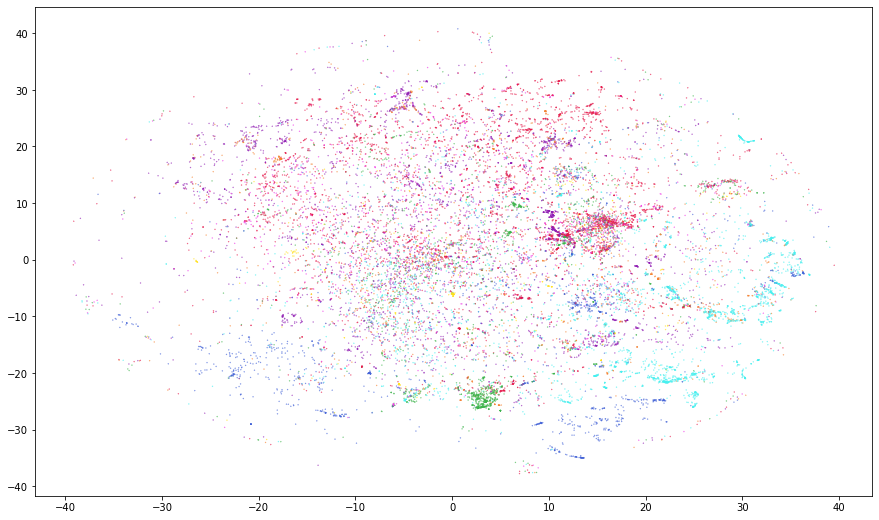

In [34]:
#UniqueInchikey 2D - note that point size is bigger here
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(np.take(tsne_2d_res[:,0], uniq_ids),np.take(tsne_2d_res[:,1], uniq_ids), 0.09,
            c=[spectra_chosen_classes[i] for i in uniq_ids])
plt.show()

Showing classes for: npc_pathway_results


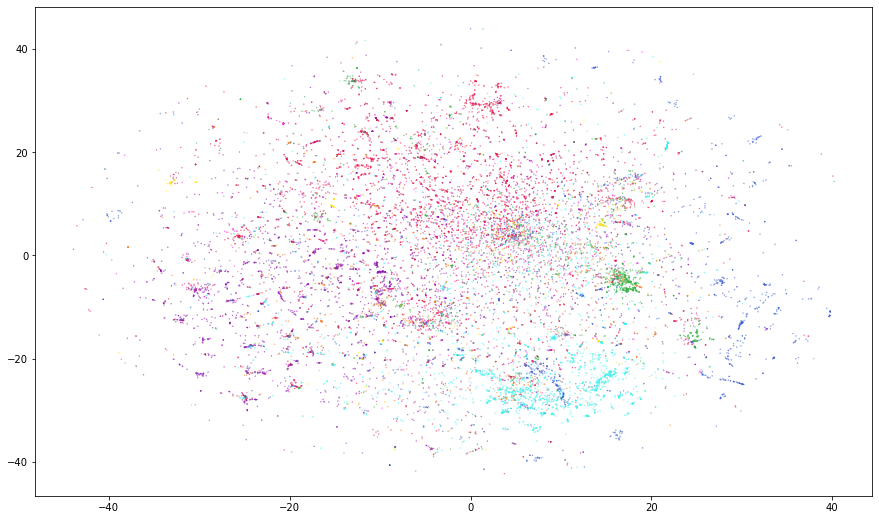

In [41]:
#UniqueInchikey 2D - weighted - note that point size is bigger here
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(np.take(tsne_2d_w_res[:,0], uniq_ids),np.take(tsne_2d_w_res[:,1], uniq_ids), 0.09,
            c=[spectra_chosen_classes[i] for i in uniq_ids])
plt.show()

Showing classes for: npc_pathway_results


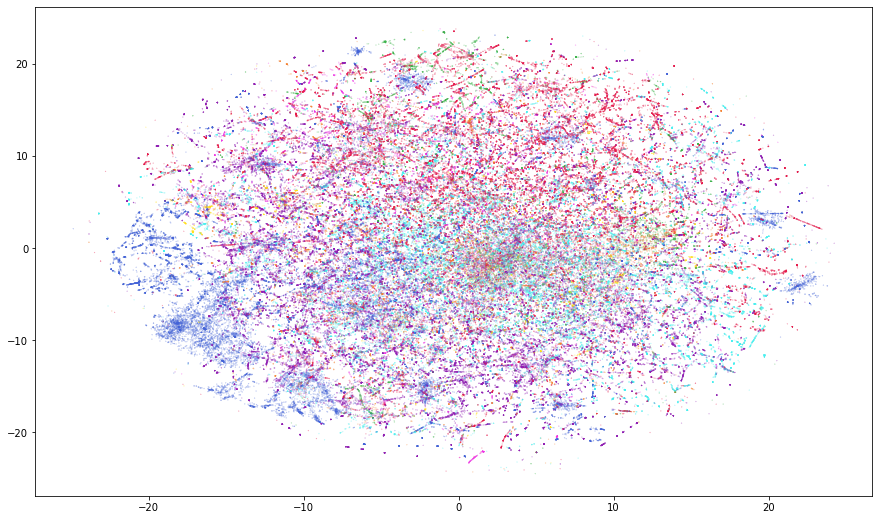

In [48]:
# Whole dataset 3D - weighted
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(tsne_3d_w_res[:,0],tsne_3d_w_res[:,1], 0.02, c=spectra_chosen_classes, label=chosen_classes)
plt.show()

Showing classes for: npc_pathway_results


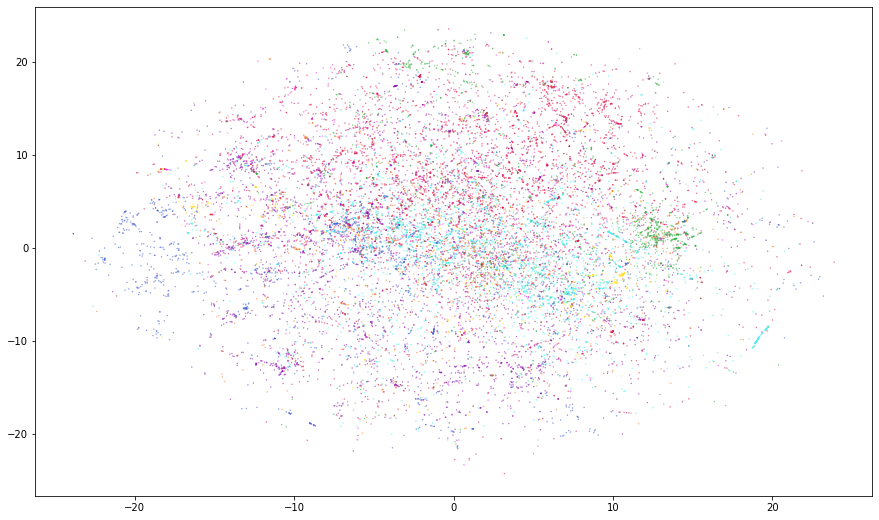

In [49]:
#UniqueInchikey 3D - weighted - point size is bigger than previous plot
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(np.take(tsne_3d_w_res[:,0], uniq_ids),np.take(tsne_3d_w_res[:,1], uniq_ids), 0.09,
            c=[spectra_chosen_classes[i] for i in uniq_ids])
plt.show()